In [2]:
import pandas as pd
import re
import numpy as np
from nltk import word_tokenize
from nltk.classify import NaiveBayesClassifier
import nltk.classify.util
from nltk.corpus import stopwords

## Exploración y transformación de datos

In [3]:
df_cell_phones = pd.read_csv('amazon-cell-phones-reviews/20190928-items.csv')
df_cell_phones.head(2)

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,prices
0,B0000SX2UC,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,2.9,https://www.amazon.com/product-reviews/B0009N5L7K,7,$49.95


In [4]:
df_reviews = pd.read_csv('amazon-cell-phones-reviews/20190928-reviews.csv')
df_reviews.head(2)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0


In [5]:
df_reviews_merge = pd.merge(df_reviews, df_cell_phones, how="left", left_on="asin", right_on="asin")
print(df_reviews_merge.shape)
df_reviews_merge.head(2)

(82815, 16)


,asin,name,rating_x,date,verified,title_x,body,helpfulVotes,brand,title_y,url,image,rating_y,reviewUrl,totalReviews,prices
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN


In [6]:
## Agregar columna 'appreciation'
df_reviews_merge.loc[df_reviews['rating'] <= 3, 'appreciation'] = 0
df_reviews_merge.loc[df_reviews['rating'] > 3, 'appreciation'] = 1
#df_reviews_merge.loc[df_reviews['rating'] == 3, 'appreciation'] = 0
stop_words = set(stopwords.words('english'))


## Obtener datos para el modelo(entrenamiento y test)

In [7]:
#threshold_factor = 0.7
#model_index = int(threshold_factor * len(df_reviews))
df_model_data = df_reviews_merge

threshold_factor = 0.8

positive_reviews = df_model_data[df_model_data['appreciation'] == 1]
negative_reviews = df_model_data[df_model_data['appreciation'] <= 0]
#neutral_reviews = df_model_data[df_model_data['appreciation'] == 0]


In [8]:
print(positive_reviews.shape[0])
print(negative_reviews.shape[0])

55722
27093


In [9]:
# definir funciones
def get_list_words(reviews_str):
    token = str(reviews_str)
    return re.sub("[^\w]", " ",  token).split()

def extract_features(word_list):
    return dict([(word, True) for word in word_list if word.lower() not in stop_words])


In [10]:
positive_series = [get_list_words(review) for review in positive_reviews['body'].values]
negative_series = [get_list_words(review) for review in negative_reviews['body'].values]
#neutral_series = [get_list_words(review) for review in neutral_reviews['body'].values]

positive_features = [(extract_features(a_review), 'Positive') for a_review in positive_series]
negative_features = [(extract_features(a_review), 'Negative') for a_review in negative_series]
#neutral_features = [(extract_features(a_review), 'Neutral') for a_review in neutral_series]

### Separar dataset para entrenamiento y pruebas

In [11]:
# Split the data into train and test (80/20)
threshold_factor = 0.8
threshold_positive = int(threshold_factor * len(positive_features))
threshold_negative = int(threshold_factor * len(negative_features))
#threshold_neutral = int(threshold_factor * len(neutral_features))

features_train = positive_features[:threshold_positive] + negative_features[:threshold_negative]
features_test = positive_features[threshold_positive:] + negative_features[threshold_negative:]

print("\nNumber of training datapoints:", len(features_train))
print("Number of test datapoints:", len(features_test))


Number of training datapoints: 66251
Number of test datapoints: 16564


### Entrenar con NaiveBayes

In [12]:
# Train a Naive Bayes classifier
classifier = NaiveBayesClassifier.train(features_train)
print("\nAccuracy of the classifier:", nltk.classify.util.accuracy(classifier, features_test))
classifier.show_most_informative_features(15)


Accuracy of the classifier: 0.8347621347500603
Most Informative Features
                   Waste = True           Negati : Positi =    114.5 : 1.0
               Excelente = True           Positi : Negati =     99.4 : 1.0
                Horrible = True           Negati : Positi =     84.3 : 1.0
                Terrible = True           Negati : Positi =     76.7 : 1.0
                   Worst = True           Negati : Positi =     72.6 : 1.0
                    Junk = True           Negati : Positi =     52.8 : 1.0
                   Avoid = True           Negati : Positi =     48.7 : 1.0
                    buen = True           Positi : Negati =     47.5 : 1.0
                  Wasted = True           Negati : Positi =     47.3 : 1.0
               excelente = True           Positi : Negati =     45.2 : 1.0
              Constantly = True           Negati : Positi =     41.8 : 1.0
                  Return = True           Negati : Positi =     39.9 : 1.0
                 Perfect =

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
word_importance_dict = {}
m_length = 30
for item in classifier.most_informative_features()[:m_length]:
    word_importance_dict[item[0]] = m_length
    m_length = m_length - 1
word_importance_dict


{'Waste': 30,
 'Excelente': 29,
 'Horrible': 28,
 'Terrible': 27,
 'Worst': 26,
 'Junk': 25,
 'Avoid': 24,
 'buen': 23,
 'Wasted': 22,
 'excelente': 21,
 'Constantly': 20,
 'Return': 19,
 'Perfect': 18,
 'Excelent': 17,
 'flickers': 16,
 'False': 15,
 'STOLEN': 14,
 'Returning': 13,
 'BEWARE': 12,
 'requesting': 11,
 'Awesome': 10,
 'Kept': 9,
 'LOCKED': 8,
 'paperweight': 7,
 'Defective': 6,
 'POS': 5,
 'Returned': 4,
 'motherboard': 3,
 'cheated': 2,
 'Broken': 1}

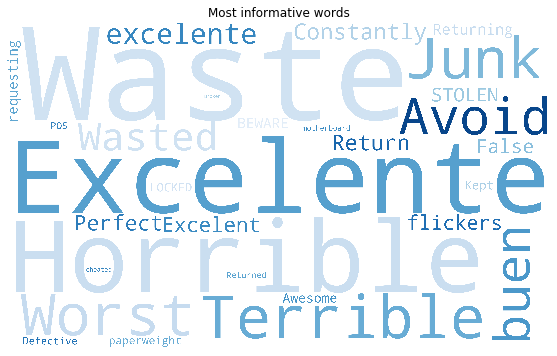

In [31]:
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
title = 'Most informative words'
wordcloud.generate_from_frequencies(word_importance_dict)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title(title)
plt.show()

### Entrenar con otros clasificadores

In [14]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC


In [15]:
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, features_test))*100)
classifier.show_most_informative_features(15)

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(features_train)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, features_test))*100)

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(features_train)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, features_test))*100)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression(solver='lbfgs', multi_class='auto'))
LogisticRegression_classifier.train(features_train)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, features_test))*100)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(features_train)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, features_test))*100)

#SVC_classifier = SklearnClassifier(SVC())
#SVC_classifier.train(features_train)
#print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, features_test))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(features_train)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, features_test))*100)

#NuSVC_classifier = SklearnClassifier(NuSVC(gamma='auto'))
#NuSVC_classifier.train(features_train)
#print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, features_test))*100)

Original Naive Bayes Algo accuracy percent: 83.47621347500603
Most Informative Features
                   Waste = True           Negati : Positi =    114.5 : 1.0
               Excelente = True           Positi : Negati =     99.4 : 1.0
                Horrible = True           Negati : Positi =     84.3 : 1.0
                Terrible = True           Negati : Positi =     76.7 : 1.0
                   Worst = True           Negati : Positi =     72.6 : 1.0
                    Junk = True           Negati : Positi =     52.8 : 1.0
                   Avoid = True           Negati : Positi =     48.7 : 1.0
                    buen = True           Positi : Negati =     47.5 : 1.0
                  Wasted = True           Negati : Positi =     47.3 : 1.0
               excelente = True           Positi : Negati =     45.2 : 1.0
              Constantly = True           Negati : Positi =     41.8 : 1.0
                  Return = True           Negati : Positi =     39.9 : 1.0
            

C:\Users\e-rbnunez\AppData\Local\Continuum\anaconda3\envs\cerounoDS\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression_classifier accuracy percent: 87.37623762376238
SGDClassifier_classifier accuracy percent: 87.49698140545762


C:\Users\e-rbnunez\AppData\Local\Continuum\anaconda3\envs\cerounoDS\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC_classifier accuracy percent: 85.75827094904612


### Crear mi propio Clasificador que combina los anteriores

In [16]:
from nltk.classify import ClassifierI
from statistics import mode
from collections import Counter

class UnoceroClassifier(ClassifierI):
    
    def __init__(self, *classifiers):
        self._classifiers = classifiers
    
    def classify(self, features):
        votes = []
        for a_classifier in self._classifiers:
            a_vote = a_classifier.classify(features)
            votes.append(a_vote)
        m_counter = Counter(votes)
        return m_counter.most_common(1)[0][0]
    
    def confidence(self, features):
        votes = []
        for a_classifier in self._classifiers:
            a_vote = a_classifier.classify(features)
            votes.append(a_vote)
        m_counter = Counter(votes)
        most_common = m_counter.most_common(1)[0][0]
        choice_votes = votes.count(most_common)
        return choice_votes / len(votes)
    
    def prob_classify(self, features, sample_target):
        tag = self.classify(features)
        a_confidence = self.confidence(features)
        return a_confidence if tag == sample_target else 1 - a_confidence

In [17]:
unocero_classifier = UnoceroClassifier(classifier,
                                  LinearSVC_classifier,
                                  SGDClassifier_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

print("unocero_classifier accuracy percent:", (nltk.classify.accuracy(unocero_classifier, features_test))*100)

unocero_classifier accuracy percent: 88.07655155759478


In [18]:
a_test = features_test[0][0]
#print(f'Clasificar la reseña:{a_test}')
a_pred_classify = unocero_classifier.classify(a_test)
confidence = unocero_classifier.confidence(a_test)
prob_dist = unocero_classifier.prob_classify(a_test, a_pred_classify)
print("Classification:", a_pred_classify, "Confidence %:", confidence*100,)

a_test = features_test[25][0]
#print(f'Clasificar la reseña:{a_test}')
a_pred_classify = unocero_classifier.classify(a_test)
confidence = unocero_classifier.confidence(a_test)
prob_dist = unocero_classifier.prob_classify(a_test, a_pred_classify)

print("Classification:", a_pred_classify, "Confidence %:", confidence*100,)



Classification: Positive Confidence %: 66.66666666666666
Classification: Positive Confidence %: 100.0


In [33]:
predicted = [unocero_classifier.classify(a_feature[0]) for a_feature in features_test]
real = [a_feature[1] for a_feature in features_test]

In [ ]:
naive_predicted = [classifier.classify(a_feature[0]) for a_feature in features_test]

In [ ]:
#print(f'{np.shape(predicted)}  {np.shape(real)}')
pd.crosstab(np.array(real), np.array(predicted), rownames=['Actual Rate'], colnames=['Predicted Rate'])

In [ ]:
pd.crosstab(np.array(real), np.array(naive_predicted), rownames=['Actual Rate'], colnames=['Predicted Rate'])

In [ ]:
real_classification = [1 if a_feature[1] == 'Positive' else 0 for a_feature in features_test]
pred_classification = [classifier.prob_classify(a_feature[0]).prob(a_feature[1]) for a_feature in features_test]

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import norm

fpr, tpr, thresholds = roc_curve(np.array(real_classification), np.array(pred_classification), pos_label = 1)
plt.figure(1)
plt.plot([1, 0], [1, 0], 'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
real_classification = [1 if a_feature[1] == 'Positive' else 0 for a_feature in features_test]
pred_classification = [classifier.prob_classify(a_feature[0]).prob('Positive') for a_feature in features_test]

In [ ]:
fpr, tpr, thresholds = roc_curve(np.array(real_classification), np.array(pred_classification), pos_label = 1)
plt.figure(1)
plt.plot([1, 0], [1, 0], 'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Analisis de sentimiento con unocero_classifier

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")

df = pd.DataFrame({'reviews': predicted})
sns.countplot(df['reviews'], palette = ['blue', 'red'])

In [ ]:

df = pd.DataFrame({'reviews': real})
sns.countplot(df['reviews'], palette = ['blue', 'red'])